In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.include import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
# latt_size = (16, 16, 16, 16)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
latt_size = (8, 8, 8, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
# mass = 0.05
# mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True


    @@@@@@######QCU NOTES START######@@@@@@@
    Guide:
    0. Required: MPI(e.g. 4.1.2), CUDA(e.g. 12.4), CMAKE(e.g. 3.22.1), GCC(e.g. 11.4.0), HDF5-MPI(e.g. 1.10.7,'apt install libhdf5-mpi-dev && export HDF5_MPI="ON" && pip install --no-binary=h5py h5py').
    1. The libqcu.so was compiled when pyqcu setup in download_path/PyQCU/lib, please add this path to your LD_LIBRARY_PATH.
    2. The QCU(PyQCU) splite grid by x->y->z->t, lattice by x->y->z->t->p->d[x,y,z,t]->c->c or x->y->z->t->c->s(->p) and x->y->z->t->c->s->c->s(->p).
    3. The QUDA(PyQUDA) splite grid by t->z->y->x, lattice by c->c->x->y->z->t->p->d[x,y,z,t] or c->s->x->y->z->t(->p) and c->s->c->s->x->y->z->t(->p).
    4. The QCU input params in numpy array(dtype=np.int32), argv in  numpy array(dtype=np.float32 or float64) array, set_ptrs in numpy array(dtype=np.int64), other in cupy array(dtype=cp.complex64 or complex128).
    5. The smallest lattice size is (wilson:x=4,y=4,z=4,t=4;clover:x=8,y=8,z=8,t=8) that QCU support

In [2]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.1685346641519847e-16


In [3]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U=U,
                clover=clover, clover_term=clover.add_I(clover_term=clover_term), verbose=verbose, max_iter=20, max_levels=5)

self.dof_list:[12, 24, 8, 8, 4, 4, 4, 24, 12, 12, 12, 24, 24, 24, 24, 48, 48, 24, 8, 8, 8, 4, 12, 12, 12, 8, 4, 2, 4, 4, 24, 12, 12, 12, 4, 4, 4, 4, 4]
Building grid list:
  Level 0: 8x8x8x16
  Level 1: 4x4x4x8
  Level 2: 2x2x2x4
self.grid_list:[[16, 8, 8, 8], [8, 4, 4, 4], [4, 2, 2, 2]]
Norm of b:352.08230511122247
Norm of r:498.5425963846596
Norm of x0:313.8520289202194
BICGSTAB-Iteration 0: Residual = 8.580277e+01, Time = 0.007168 s
BICGSTAB-Iteration 1: Residual = 2.822861e+01, Time = 0.007083 s
BICGSTAB-Iteration 2: Residual = 5.273241e+01, Time = 0.006634 s
BICGSTAB-Iteration 3: Residual = 9.527418e+00, Time = 0.006660 s
BICGSTAB-Iteration 4: Residual = 7.033713e+00, Time = 0.006572 s
BICGSTAB-Iteration 5: Residual = 4.071705e+00, Time = 0.006770 s
BICGSTAB-Iteration 6: Residual = 3.057178e+00, Time = 0.006560 s
BICGSTAB-Iteration 7: Residual = 2.872462e+00, Time = 0.006779 s
BICGSTAB-Iteration 8: Residual = 1.024107e+01, Time = 0.006566 s
BICGSTAB-Iteration 9: Residual = 5.09933

In [4]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [5]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 2.7 ms, sys: 184 μs, total: 2.89 ms
Wall time: 2.63 ms
CPU times: user 1.37 ms, sys: 0 ns, total: 1.37 ms
Wall time: 1.3 ms
313.53468707624677
15.064980658884766
351.530776679681
351.530776679681
1.741567544887391e-16
CPU times: user 31.6 ms, sys: 221 μs, total: 31.8 ms
Wall time: 31.1 ms


In [6]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 4.69 ms, sys: 0 ns, total: 4.69 ms
Wall time: 3.66 ms
CPU times: user 2.33 ms, sys: 0 ns, total: 2.33 ms
Wall time: 2.07 ms


In [7]:
b0 = mg.b_list[0]
b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
_b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
_b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
print(_b1.flatten()[:100]/b1.flatten()[:100])

restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
prolong:shape,fine_dof:(torch.Size([24, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
tensor([1.0000+2.4267e-16j, 1.0000-2.8126e-16j, 1.0000-1.8382e-17j,
        1.0000+2.4465e-16j, 1.0000+9.1104e-17j, 1.0000+3.1809e-16j,
        1.0000+4.7232e-16j, 1.0000+7.2792e-17j, 1.0000-2.3131e-16j,
        1.0000-3.7258e-17j, 1.0000+6.7792e-17j, 1.0000+1.8743e-16j,
        1.0000+1.1610e-16j, 1.0000-2.3581e-16j, 1.0000+2.0686e-16j,
        1.0000-8.7363e-17j, 1.0000+2.9022e-16j, 1.0000-1.2758e-17j,
        1.0000-6.6123e-16j, 1.0000-1.3311e-16j, 1.0000-2.3328e-16j,
        1.0000-2.4672e-16j, 1.0000-2.9319e-17j, 1.0000+1.2217e-16j,
        1.0000+3.9138e-16j, 1.0000-2.2576e-16j, 1.0000+7.4210e-17j,
        1.0000-6.8617e-17j, 1.0000+9.5497e-18j, 1.0000-5.6210e-17j,
        

In [8]:
# _x = inverse.cg(b=b, matvec=matvec, verbose=verbose)
_x = inverse.bicgstab(b=b, matvec=_matvec, verbose=verbose)
# _x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, verbose=verbose)

Norm of b:313.60298027911824
Norm of r:471.5783110951797
Norm of x0:313.4807957459737
BICGSTAB-Iteration 0: Residual = 1.021707e+02, Time = 0.006848 s
BICGSTAB-Iteration 1: Residual = 4.336063e+01, Time = 0.006786 s
BICGSTAB-Iteration 2: Residual = 4.434381e+01, Time = 0.006542 s
BICGSTAB-Iteration 3: Residual = 2.957296e+01, Time = 0.006682 s
BICGSTAB-Iteration 4: Residual = 1.881218e+01, Time = 0.007619 s
BICGSTAB-Iteration 5: Residual = 2.214857e+01, Time = 0.006877 s
BICGSTAB-Iteration 6: Residual = 2.058866e+01, Time = 0.007174 s
BICGSTAB-Iteration 7: Residual = 1.681485e+01, Time = 0.006349 s
BICGSTAB-Iteration 8: Residual = 1.308367e+01, Time = 0.006826 s
BICGSTAB-Iteration 9: Residual = 1.384685e+01, Time = 0.006551 s
BICGSTAB-Iteration 10: Residual = 1.116694e+01, Time = 0.006724 s
BICGSTAB-Iteration 11: Residual = 9.333700e+00, Time = 0.007302 s
BICGSTAB-Iteration 12: Residual = 1.232087e+01, Time = 0.006742 s
BICGSTAB-Iteration 13: Residual = 2.610373e+01, Time = 0.006750 s


MG-0:Norm of b:313.60298027911824
MG-0:Norm of r:470.9058956921938
MG-0:Norm of x0:313.6571499196715
B-MG-0-BICGSTAB-Iteration 0: Residual = 1.020887e+02
restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-1:Norm of b:54.80161567851482
MG-1:Norm of r:403.8617211274031
MG-1:Norm of x0:110.0686616732915
B-MG-1-BICGSTAB-Iteration 0: Residual = 3.828053e+00
restrict:shape,coarse_dof:(torch.Size([8, 24, 4, 2, 2, 2, 2, 2, 2, 2]), 8)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-2:Norm of b:0.7910843564572756
MG-2:Norm of r:241.3349296443357
MG-2:Norm of x0:16.983464923338005
B-MG-2-BICGSTAB-Iteration 0: Residual = 4.609458e-02
F-MG-2-BICGSTAB-Iteration 0: Residual = 4.609458e-02, Time = 0.002166 s
B-MG-2-BICGSTAB-Iteration 1: Residual = 1.182098e-05
F-MG-2-BICGSTAB-Iteration 1: Residual = 1.182098e-05, Time = 0.002432 s
Converged at iteration 1 with residual 1.182098e-05

Performance Statistics:
Total iterations: 2
Total time: 0.004626 seconds
Average

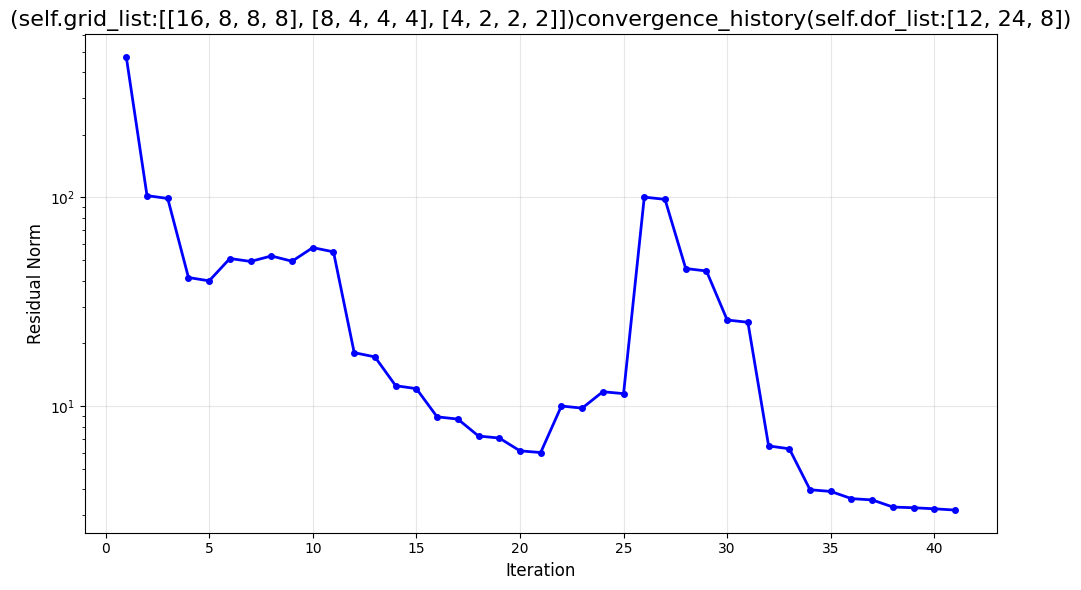

In [23]:
mg.max_iter=20
mg.convergence_history=[]
x = mg.solve()
mg.plot()

In [10]:
mg.lonv_list[0].shape

torch.Size([24, 12, 8, 2, 4, 2, 4, 2, 4, 2])

In [11]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([-0.0060-0.0076j, -0.0032-0.0081j, -0.0034-0.0065j, -0.0038-0.0106j,
        -0.0019-0.0091j, -0.0044-0.0136j, -0.0069-0.0119j, -0.0063-0.0130j,
        -0.0050-0.0095j, -0.0022-0.0064j, -0.0010-0.0085j, -0.0019-0.0066j,
        -0.0009-0.0110j, -0.0024-0.0089j, -0.0058-0.0125j, -0.0066-0.0093j,
        -0.0031-0.0097j, -0.0021-0.0095j, -0.0018-0.0074j, -0.0007-0.0106j,
        -0.0025-0.0078j, -0.0045-0.0120j, -0.0046-0.0100j, -0.0067-0.0104j,
        -0.0069-0.0121j, -0.0036-0.0083j, -0.0027-0.0103j, -0.0036-0.0093j,
        -0.0026-0.0119j, -0.0041-0.0084j, -0.0054-0.0119j, -0.0054-0.0111j,
        -0.0067-0.0096j, -0.0066-0.0103j, -0.0037-0.0084j, -0.0025-0.0114j,
        -0.0048-0.0102j, -0.0024-0.0142j, -0.0057-0.0109j, -0.0084-0.0129j,
        -0.0081-0.0104j, -0.0056-0.0077j, -0.0053-0.0101j, -0.0030-0.0110j,
        -0.0040-0.0138j, -0.0081-0.0114j, -0.0065-0.0157j, -0.0079-0.0084j,
        -0.0068-0.0083j, -0.0057-0.0093j, -0.0046-0.0085j, -0.0043-0.0127j,
        -0.0

In [12]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

0.5050522142277992


In [13]:
mg.num_levels

3

In [21]:
index = 1
null_vecs = mg.nv_list[index]
matvec = mg.op_list[index].matvec
for i in range(null_vecs.shape[0]):
    print(
        f"(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:{(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]}")

(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([2.9201+0.2116j, 3.4234-0.1561j, 3.1873+0.3741j, 3.3843+0.8748j,
        3.2370+0.0269j, 3.4520+0.1136j, 3.2039+0.3226j, 3.1641+0.1860j,
        3.5408+0.3567j, 3.1252+0.4279j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([3.4373+0.4564j, 2.9900-0.0327j, 3.7266+0.5977j, 3.4545-1.0670j,
        3.1967+0.1807j, 3.0589-0.0232j, 3.1980-0.2645j, 3.3955+0.1782j,
        3.3432+0.1541j, 3.2639-0.1831j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([3.5991-0.0271j, 3.3306+0.4078j, 1.6038+0.2218j, 3.3418+0.0514j,
        3.2957-0.1314j, 2.6683+0.2056j, 2.8455+0.0747j, 3.4202+0.2536j,
        2.9615+0.5028j, 2.9891-0.2536j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([4.1299+0.8115j, 2.9489-0.1069j, 3.1363-0.1698j, 2.7235-0.2198j,
        3.4636-0.3198j, 5

In [15]:
mg.nv_list[-1].flatten()[:100]

tensor([-6.1477e-03-0.0043j, -4.7454e-03-0.0062j,  9.7614e-04-0.0060j,
         1.3983e-03-0.0040j, -2.9722e-03-0.0101j,  1.1163e-03-0.0120j,
         6.9170e-03-0.0116j,  7.1264e-03-0.0051j, -1.9840e-03-0.0047j,
        -1.3579e-03-0.0077j, -1.2348e-03-0.0113j,  2.1499e-04+0.0034j,
        -7.8714e-03+0.0018j, -6.0069e-03-0.0038j, -4.9564e-03-0.0036j,
        -4.3213e-03+0.0026j, -1.0868e-02+0.0072j, -1.0949e-02-0.0060j,
        -3.0669e-03-0.0074j, -1.3249e-02+0.0015j, -1.0203e-02-0.0024j,
        -7.5699e-03-0.0046j,  1.0098e-04-0.0100j,  2.6648e-04-0.0033j,
        -1.0217e-02-0.0004j, -5.2988e-03-0.0091j, -2.5714e-03-0.0066j,
        -5.8302e-03-0.0015j, -3.3622e-03-0.0026j, -1.0378e-02+0.0044j,
        -2.0085e-02-0.0042j, -1.1154e-02+0.0057j, -3.6348e-03-0.0044j,
         2.4356e-04-0.0022j, -1.1701e-02-0.0188j, -5.9805e-03-0.0086j,
        -3.6524e-03+0.0076j, -3.3870e-03+0.0051j,  6.1777e-03-0.0075j,
        -1.4106e-03-0.0013j,  2.4111e-03+0.0042j, -1.1354e-03-0.0034j,
      

In [16]:
_null_vec = torch.randn_like(null_vecs[0])
print(torch.norm(matvec(_null_vec)))
print(matvec(_null_vec).flatten()[:20])
_null_vec -= inverse.bicgstab(b=matvec(_null_vec), matvec=matvec, tol=5e-5)
print(torch.norm(_null_vec))
print(_null_vec.flatten()[:20])
_null_vec/=torch.norm(_null_vec).item()
print(
    f"(matvec(_null_vec)/_null_vec).flatten()[:10]:{(matvec(_null_vec)/_null_vec).flatten()[:10]}")

tensor(351.6107, device='cuda:0', dtype=torch.float64)
tensor([-3.7495e-01-1.6925j,  1.3640e-02-0.1579j,  1.6947e-01-0.2727j,
        -2.5855e-01+0.2090j, -6.0396e-01+0.4666j, -2.2911e-01+0.7156j,
         1.0981e+00-1.1967j,  1.7508e+00+1.6293j, -5.2652e-01+1.2448j,
        -4.7800e-01+0.1245j,  1.7845e-04+0.0589j, -5.0290e-01+0.4842j,
         8.3693e-01+1.4416j, -1.2083e-01-0.5062j, -2.5013e-01-0.0218j,
        -4.9379e-01+0.2689j,  7.8036e-01-1.4893j,  3.9896e-01+0.8183j,
        -1.2806e+00-1.2164j,  1.0032e+00-0.2346j], device='cuda:0',
       dtype=torch.complex128)


Norm of b:351.6107208425924
Norm of r:498.8906915340981
Norm of x0:314.22461629895184
BICGSTAB-Iteration 0: Residual = 8.603598e+01, Time = 0.006423 s
BICGSTAB-Iteration 1: Residual = 2.825455e+01, Time = 0.006738 s
BICGSTAB-Iteration 2: Residual = 5.713347e+01, Time = 0.006650 s
BICGSTAB-Iteration 3: Residual = 9.485201e+00, Time = 0.006404 s
BICGSTAB-Iteration 4: Residual = 6.585138e+00, Time = 0.006909 s
BICGSTAB-Iteration 5: Residual = 3.846772e+00, Time = 0.007244 s
BICGSTAB-Iteration 6: Residual = 2.943534e+00, Time = 0.006623 s
BICGSTAB-Iteration 7: Residual = 4.227182e+00, Time = 0.006804 s
BICGSTAB-Iteration 8: Residual = 2.730253e+00, Time = 0.006814 s
BICGSTAB-Iteration 9: Residual = 1.692792e+00, Time = 0.007044 s
BICGSTAB-Iteration 10: Residual = 1.333471e+00, Time = 0.007060 s
BICGSTAB-Iteration 11: Residual = 7.969920e-01, Time = 0.006884 s
BICGSTAB-Iteration 12: Residual = 7.546611e-01, Time = 0.006517 s
BICGSTAB-Iteration 13: Residual = 5.886981e-01, Time = 0.006778 s


In [17]:
_b = torch.randn_like(null_vecs[0])
_x = inverse.bicgstab(b=_b, matvec=matvec, tol=1e-8)
print((_b-matvec(_x)).flatten()[:100])
print(torch.norm(_b))
print(torch.norm(_x))

Norm of b:313.1537531912454
Norm of r:471.26872668326405
Norm of x0:313.8209039178004
BICGSTAB-Iteration 0: Residual = 1.021567e+02, Time = 0.006982 s
BICGSTAB-Iteration 1: Residual = 4.591813e+01, Time = 0.006981 s
BICGSTAB-Iteration 2: Residual = 4.378933e+01, Time = 0.006903 s
BICGSTAB-Iteration 3: Residual = 3.105691e+01, Time = 0.006854 s
BICGSTAB-Iteration 4: Residual = 1.900905e+01, Time = 0.006673 s
BICGSTAB-Iteration 5: Residual = 1.367225e+01, Time = 0.006569 s
BICGSTAB-Iteration 6: Residual = 1.325973e+01, Time = 0.007027 s
BICGSTAB-Iteration 7: Residual = 1.610926e+01, Time = 0.006454 s
BICGSTAB-Iteration 8: Residual = 7.406090e+00, Time = 0.007250 s
BICGSTAB-Iteration 9: Residual = 7.425341e+00, Time = 0.006636 s
BICGSTAB-Iteration 10: Residual = 1.406577e+01, Time = 0.006927 s
BICGSTAB-Iteration 11: Residual = 8.128735e+00, Time = 0.006791 s
BICGSTAB-Iteration 12: Residual = 1.029811e+01, Time = 0.006786 s
BICGSTAB-Iteration 13: Residual = 7.450332e+00, Time = 0.007047 s


In [18]:
_null_vec.flatten()[:100]

tensor([-0.0007-0.0029j, -0.0010-0.0033j, -0.0008-0.0030j, -0.0013-0.0030j,
        -0.0008-0.0022j, -0.0011-0.0026j, -0.0008-0.0033j, -0.0006-0.0031j,
        -0.0015-0.0030j, -0.0019-0.0029j, -0.0010-0.0031j, -0.0013-0.0027j,
        -0.0008-0.0025j, -0.0011-0.0029j, -0.0013-0.0029j, -0.0005-0.0033j,
        -0.0009-0.0033j, -0.0012-0.0029j, -0.0011-0.0034j, -0.0007-0.0031j,
        -0.0006-0.0026j, -0.0010-0.0027j, -0.0014-0.0033j, -0.0009-0.0035j,
        -0.0010-0.0033j, -0.0011-0.0031j, -0.0005-0.0029j, -0.0006-0.0036j,
        -0.0009-0.0033j, -0.0010-0.0027j, -0.0020-0.0030j, -0.0014-0.0030j,
        -0.0011-0.0032j, -0.0013-0.0031j, -0.0013-0.0032j, -0.0010-0.0027j,
        -0.0014-0.0029j, -0.0012-0.0036j, -0.0009-0.0033j, -0.0010-0.0031j,
        -0.0015-0.0023j, -0.0010-0.0027j, -0.0004-0.0028j, -0.0008-0.0025j,
        -0.0007-0.0033j, -0.0013-0.0034j, -0.0010-0.0031j, -0.0013-0.0024j,
        -0.0010-0.0034j, -0.0009-0.0034j, -0.0009-0.0038j, -0.0006-0.0030j,
        -0.0